Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/xoab/anaconda2/lib/python2.7/site-packages/ffc/uflacs/analysis/dependencies.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


Calling FFC just-in-time (JIT) compiler, this may take some time.


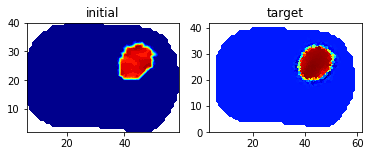

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


KeyboardInterrupt: 

In [1]:
%matplotlib inline
from __future__ import print_function
from dolfin import *
from dolfin_adjoint import *
import numpy as np
import os, sys
import scipy.io as scio
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

set_log_level(ERROR) 

class InterpolatedParameter(Expression):
    '''
        Class to get tumor cell distributions by interpolating based off matrices of tumor cell data
    '''
    def __init__(self,X,Y,image,**kwargs):
        self.X = X # A numpy array giving the X-spacing of the image
        self.Y = Y # Same for Y
        self.image = image # The image of measured material property    
    def eval_cell(self,values,x,cell):
        interp_handle = RegularGridInterpolator((self.X,self.Y),self.image)
        values[0] = interp_handle(x)
        
def interp(file_loc,mat_name):
    mat = scio.loadmat(file_loc)[mat_name]
    mat = np.fliplr(mat.T)/50970.  # Needs to be adjusted to fit the mesh correctly; also scaled
    x,y = mat.shape[0], mat.shape[1]
    mat_interp = InterpolatedParameter(np.linspace(1,x,x),np.linspace(1,y,y),mat,degree=1)
    return interpolate(mat_interp,V)

def vis_obs(initial_p,target_p,title1,title2):
    '''
        Compare two quantity plots, for example initial vs. target cellularity
        Accepts titles for each plot
    '''
    target_p = interpolate(target_p,V0)
    cm1 = colors.ListedColormap([[0,1,0,1],[0,0,0,1],[1,0,0,1]])    
    cm2 = cm.get_cmap('jet')
    plt.figure()
    plt.subplot(1,2,1)
    plt.title(title1)
    plot(initial_p,cmap=cm2)
 
    plt.subplot(1,2,2)
    plt.title(title2)
    plot(target_p,cmap=cm2)
    plt.show()

def forward(initial_p,record=False):
    """ 
        Here, we define the forward problem. 
    """
    
    '''
        - E(u) returns the Green-Lagrange strain tensor
        - sigma(...) returns the actual stress tensor
        - sigma_form(...) returns the stress tensor based on the cells (phi), elasticity coefficients, and a coefficient beta
        - vonmises(...) calculates the von Mises stress based on the actual stress tensor
    '''
    # Define functions
    def E(u):
        return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    def sigma(u):
        I = Identity(2)             # Identity tensor
        F = I + grad(u)             # Deformation gradient
        B = F*F.T
        C = F.T*F
        J = det(F)
        I1 = tr(C)
        sigma = lmbda*(J-1)*I+mu*(B-1./2*I1*I)/(J**(5./3))
        return sigma
    def vonmises(u):
        s = sigma(u) - (1./2)*tr(sigma(u))*Identity(2)  # deviatoric stress
        von_Mises = sqrt(3./2*inner(s, s))
        return project(von_Mises, V)
    def sigma_form(u, phi):
        I = Identity(2)             # Identity tensor
        F = I + grad(u)             # Deformation gradient
        Fs = F/(1+beta*phi)
        Bs = Fs*Fs.T
        Js  = det(Fs)
        return 1/(1+beta*phi)*(mu/(Js**(5./3))*(Bs-1./2*tr(Bs)*I)+lmbda*(Js-1)*I)

   
    k.rename('k','k field')              # field of growth rate, treated as a local parameter here
    p_n = Function(V) # current distribution of cell density (phi_T)
    p_n = interpolate(initial_p,V)
    p_n.rename('phi_T','tumor fraction')
    p = Function(V)
    q = TestFunction(V)
    
    U = VectorFunctionSpace(mesh,'Lagrange',1)
    def boundary(x, on_boundary):
        return on_boundary
    bc = DirichletBC(U, Constant((0.,0.)), boundary)
    u = Function(U) 
    u.rename('u','displacement')
    v = TestFunction(U)
    F_LE = inner(sigma_form(u, p_n), E(v))*dx
    def le():
        solve(F_LE==0, u, bc)
        return u

    disp = le()
    vm = vonmises(disp)
    D = D0*exp(-gammaD*vm)
    F_RD = (1/dt)*(p - p_n)*q*dx + D*dot(grad(q),grad(p))*dx - k*p*(1 - p/theta)*q*dx  

    # Prepare the solution
    t = 0.
    if record:        # save the current solution, k field, displacement, and diffusion
        file_results.write(p_n,t)
        file_results.write(u,t)
        file_results.write(k,t)
        D_proj = project(D,V)
        vm.rename("vm","Von Mises")
        D_proj.rename("D","diffusion coefficient")
        file_results.write(vm,t)
        file_results.write(D_proj,t)
        
    for n in range(num_steps):
        # Update current time
        t += dt
        
        # Compute solution
        solve(F_RD == 0, p) # with trivial Neumann BC

        # Update previous solution
        p_n.assign(p)
        disp = le()
        vm   = vonmises(disp)
        D    = D0*exp(-gammaD*vm)
        
        if record:        # save the current solution, k field, displacement, and diffusion
            file_results.write(p_n,t)
            file_results.write(u,t)
            file_results.write(k,t)
            D_proj = project(D,V)
            D_proj.rename("D","diffusion coefficient")
            file_results.write(vm,t)
            file_results.write(D_proj,t)

    return p

# Callback function for the optimizer
# Writes intermediate results to a logfile
def eval_cb(j, m):
    """ The callback function keeping a log """
    print("objective = %15.10e " % j)

def objective(p, target_p, r_coeff1, r_coeff2):
    return assemble(inner(p-target_p, p-target_p)*dx) + r_coeff1*assemble(k*k*dx) + r_coeff2*assemble(dot(grad(k),grad(k))*dx)

def optimize(dbg=False):
    """ The optimization routine """
    # Define the control
    m = [Control(k), Control(D0)]
    
    # Execute first time to annotate and record the tape
    p = forward(initial_p,True)

    J = objective(p, target_p, r_coeff1, r_coeff2)

    # Prepare the reduced functional
    rf = ReducedFunctional(J,m,eval_cb_post=eval_cb)

    # Run the optimization
    m_opt = minimize(rf,method='L-BFGS-B', tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    
    return m_opt

#########################################################################
# MAIN 
#########################################################################
t1         = time()
case       = 0
r_coeff1   = 0.01
r_coeff2   = 0.01
input_dir  = "../rat-data/rat05/"
output_dir = './output/rat05'

# Prepare output file
file_results = XDMFFile(os.path.join(output_dir,'optimal.xdmf'))
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

# Prepare a mesh
mesh = Mesh(input_dir+"gmsh.xml")
V0   = FunctionSpace(mesh, 'DG', 0)
V    = FunctionSpace(mesh, 'CG', 1)

# Load initial tumor condition data
initial_p = interp(input_dir+"ic.mat","ic")
initial_p.rename('initial','tumor at day 0')
# target_p  = interp(input_dir+"tumor_t2.mat","tumor")  
# target_p.rename('target','tumor at day 2')

# Model parameters
T             = 2.0             # final time 
num_steps     = 100              # number of time steps
dt            = T/num_steps     # time step size
theta         = 1            # carrying capacity
mu            = 10.
nu            = .45
lmbda         = 2*mu*nu/(1-2*nu)
beta          = 1.
gammaD = Constant(1.2)    # initial guess of gamma_D

# Parameters to be optimized
D0     = Constant(10.)   # mobility or diffusion coefficient
k0     = Constant(1.)    # growth rate initial guess
k      = project(k0,V)

target_p = forward(initial_p)

D0     = Constant(8.)   # mobility or diffusion coefficient
k0     = Constant(1.2)    # growth rate initial guess
k      = project(k0,V)

# Visualize initial cellularity and target cellularity
vis_obs(initial_p,target_p,'initial','target') 

# Optimization module
[k, D0] = optimize() # optimize the k field, gammaD, and D0 using the adjoint method provided by adjoint_dolfin
model_p = forward(initial_p,True) # run the forward model using the optimized k field
print('norm(k_opt) = '+str(norm(k)))
print('J_opt = '+str(objective(model_p, target_p, r_coeff1, r_coeff2)))
print('J_opt (without regularization) = '+str(objective(model_p, target_p, 0., 0.)))
print('gamma_D = '+str(gammaD.values()[0]))
print('D0 = '+str(D0.values()[0]))
print('Elapsed time is ' + str((time()-t1)/60) + ' minutes')
vis_obs(model_p,target_p,'model','actual')
plot(k)
